In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import paddle.fluid as fluid
import matplotlib.pyplot as plt

### Load data

In [3]:
# https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data
df=pd.read_csv('./data/iris.data',header=None)

### Data processing

In [4]:
flowers_label = np.asarray(sorted([0,1,2]*50)).astype(np.int64)  # target
flowers_feature = df.iloc[:,:4].values  # feature data


# shuffle
index = np.arange(150)
np.random.shuffle(index)
flowers_label = flowers_label[index]
flowers_feature = flowers_feature[index]

### Split data

In [5]:
x_valid, x_train = flowers_feature[:50],flowers_feature[50:]
y_valid, y_train = flowers_label[:50],flowers_label[50:]

### Define variables, fc(Matrix Operations), cross entropy, mean value, accuracy and optimizer

In [6]:
x = fluid.layers.data(name='x', shape=[None,4], dtype='float64')
y = fluid.layers.data(name='y', shape=[None,1], dtype='float64')

fc = fluid.layers.fc(x, size=30, act='relu')  # 30 outputs= 30 equations = 30 neurons
y_pred = fluid.layers.fc(fc, size=3, act='softmax')  # 3 outputs, softmax: choose the largest one from the probability of 3 kinds

# cross entropy
cross_entropy = fluid.layers.cross_entropy(input=y_pred, label=y)
cost = fluid.layers.mean(cross_entropy)

# accuracy
acc = fluid.layers.accuracy(input=y_pred, label=y)

# optimizer, Stochastic gradient descent (SGD)
sgd = fluid.optimizer.SGD(learning_rate=0.01)
_ = sgd.minimize(cost)

### Executor

In [7]:
use_cuda = False # CPU
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()

# executor accept the passed program and get the result from the feed map and fetch list
#    close(): close the executor
#    run(): execute the program
exe = fluid.Executor(place)
main_program = fluid.default_main_program()
test_program = main_program.clone(for_test=True)

In [8]:
exe.run(fluid.default_startup_program())  # initialize the variables
costs = []
val_costs = []
accuracys = []
val_accuracys = []

for i in range(500):
    # for main program
    cost_, acc_ = exe.run(program=main_program,
                          feed={'x':x_train, 'y':y_train.reshape(-1,1)},
                          fetch_list=[cost,acc]
                          )
    # for test program, validation
    val_cost, val_acc = exe.run(program=test_program,
                                feed={'x':x_valid,'y':y_valid.reshape(-1,1)},
                                fetch_list=[cost,acc]
                                )
    
    costs.append(cost_[0])
    accuracys.append(acc_[0])
    val_costs.append(val_cost[0])
    val_accuracys.append(val_acc[0])
    print('----------%d-----------'%(i),cost_,acc_)

df = pd.DataFrame({'loss':costs,
                   'accuracy':accuracys,
                   'val_loss':val_costs,
                   'val_accuracy':val_accuracys}
                  )

----------0----------- [1.96681513] [0.29]
----------1----------- [1.67225808] [0.29]
----------2----------- [1.5050699] [0.29]
----------3----------- [1.41676549] [0.29]
----------4----------- [1.3664424] [0.45]
----------5----------- [1.33199344] [0.4]
----------6----------- [1.30508784] [0.39]
----------7----------- [1.28168719] [0.39]
----------8----------- [1.26029475] [0.39]
----------9----------- [1.24029256] [0.39]
----------10----------- [1.22143635] [0.39]
----------11----------- [1.2033547] [0.39]
----------12----------- [1.185995] [0.39]
----------13----------- [1.16927262] [0.39]
----------14----------- [1.15307454] [0.39]
----------15----------- [1.13741887] [0.39]
----------16----------- [1.12221447] [0.39]
----------17----------- [1.10741233] [0.39]
----------18----------- [1.09298523] [0.39]
----------19----------- [1.07893321] [0.39]
----------20----------- [1.06528827] [0.39]
----------21----------- [1.05202244] [0.39]
----------22----------- [1.03911404] [0.39]
----

### Visialization

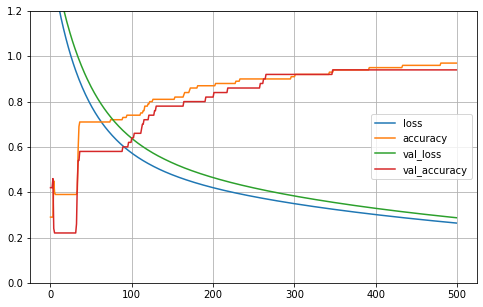

In [9]:
def plot_learning_curves(df):
    pd.DataFrame(df).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1.2)
    plt.show()
    
plot_learning_curves(df)